In [111]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle
import mtcnn
from mtcnn.mtcnn import MTCNN
%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline


In [2]:
def display_images(num_images, image_array, title, columns=1):
    '''This function displays images as they are, before any pre-processing.'''
    columns = columns
    rows = int(num_images / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4))
    fig.suptitle(title, size=20)
    ax = ax.ravel()
    for i in range(num_images):
        ax[i].imshow(image_array[i][0], cmap='gray')
        ax[i].set_title(label_mapping.get(image_array[i][1]), size=16)

In [3]:
def subplot_images(num_images, dataframe, image_indices, title, columns=4, target_width=224, target_height=224):
    '''This function displays images from a dataframe with specified indices, along with cropping and resizing.'''
    columns = columns
    rows = int(num_images / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4), sharex=True, sharey=True)
    fig.suptitle(title, size=20)
    ax = ax.ravel()
    for i, img_index in enumerate(image_indices):
        image = dataframe.loc[img_index, 'image_array']
        new_image = crop_and_resize(image, target_width=target_width, target_height=target_height)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(dataframe.loc[img_index, 'face_shape'], size=16)

In [4]:
def subplot_image_array(num_images, image_array, title, columns=4, target_width=224, target_height=224):
    '''This function displays images from an array dataset, along with cropping and resizing.'''
    columns = columns
    rows = int(num_images / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*4, rows*4), sharex=True, sharey=True)
    fig.suptitle(title, size=20)
    ax = ax.ravel()
    for i, img_data in enumerate(image_array):
        image = img_data[0]
        new_image = crop_and_resize(image, target_width=target_width, target_height=target_height)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_mapping.get(img_data[1]), size=16)

In [5]:
def print_summary(training_array, testing_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {training_array.shape}')
    print(f'Classes: {np.unique(training_array[:,1])}')
    print(f'Number of Images in each class: {np.bincount(training_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(training_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {testing_array.shape}')
    print(f'Classes: {np.unique(testing_array[:,1])}')
    print(f'Number of Images in each class: {np.bincount(testing_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(testing_array[0][0][:])}')
    print('\n--------------------------------------\n')

In [7]:
train_dir = 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/training_set'
test_dir = 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/testing_set'
categories = ['Heart','Oblong','Oval','Round','Square']

In [8]:
shape_labels = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

In [9]:
def create_data_files(directory, data_array, resize=None):
    '''This function reads images from the directory and creates training and testing datasets.'''
    data_tuples = []  # List to store tuples of image arrays and class numbers
    i = 0
    for category in categories:
        path = os.path.join(directory, category)  # Path to directory of images
        class_num = categories.index(category)  # Assigns a number to the 5 categories
        img_list = os.listdir(path)
        try:
            for img in img_list:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

                # Check if img_array is not None
                if img_array is not None:
                    if resize is not None:
                        img_array = cv2.resize(img_array, resize)
                    data_tuples.append((img_array, class_num))  # Append a tuple to the list
                    i += 1
                else:
                    print(f'Error: Image {img} is None. Skipping...')
        except Exception as e:
            print(f'Error: \n Category: {category}\n Image: {img}')

        # Print progress every 200 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list) * len(categories)}")

    # Convert list of tuples to NumPy array
    data_array.extend(data_tuples)
    print("Data creation completed.")

In [17]:

training_data = []
testing_data = []

create_data_files(train_dir, training_data)
create_data_files(test_dir, testing_data)

# convert them to numpy arrays


Images processed: 800 of 4000
Images processed: 1600 of 4000
Images processed: 2400 of 4000
Images processed: 3200 of 4000
Images processed: 4000 of 4000
Data creation completed.
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000
Data creation completed.


C:\Users\Asus\AppData\Local\Temp\ipykernel_31596\2099218474.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_data = np.asarray(training_data)
C:\Users\Asus\AppData\Local\Temp\ipykernel_31596\2099218474.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  testing_data = np.asarray(testing_data)


In [29]:

training_data = np.asarray(training_data)
testing_data = np.asarray(testing_data)


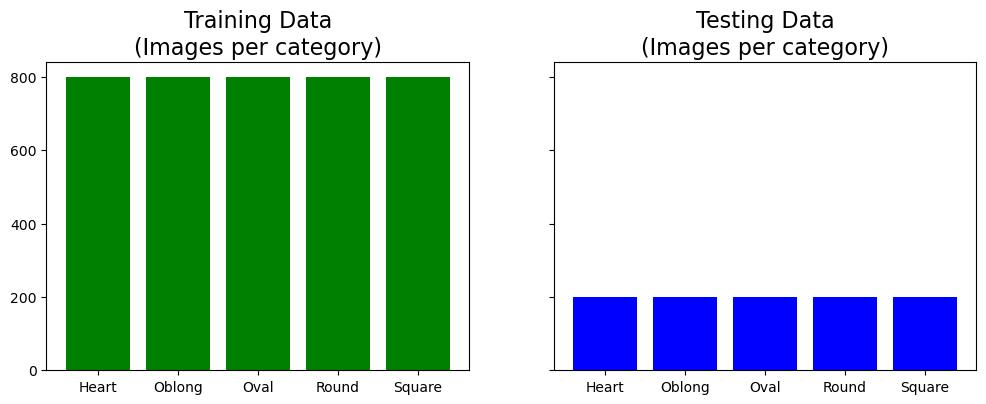

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='green')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='blue')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,801,200));

In [49]:
def show_img(num, img_array, title, label_map, ncols=1):
    '''this function display images as is - before any pre-processing'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray', vmin=0, vmax=255)  # Specify vmin and vmax for grayscale images
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)


In [52]:
label_map = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}


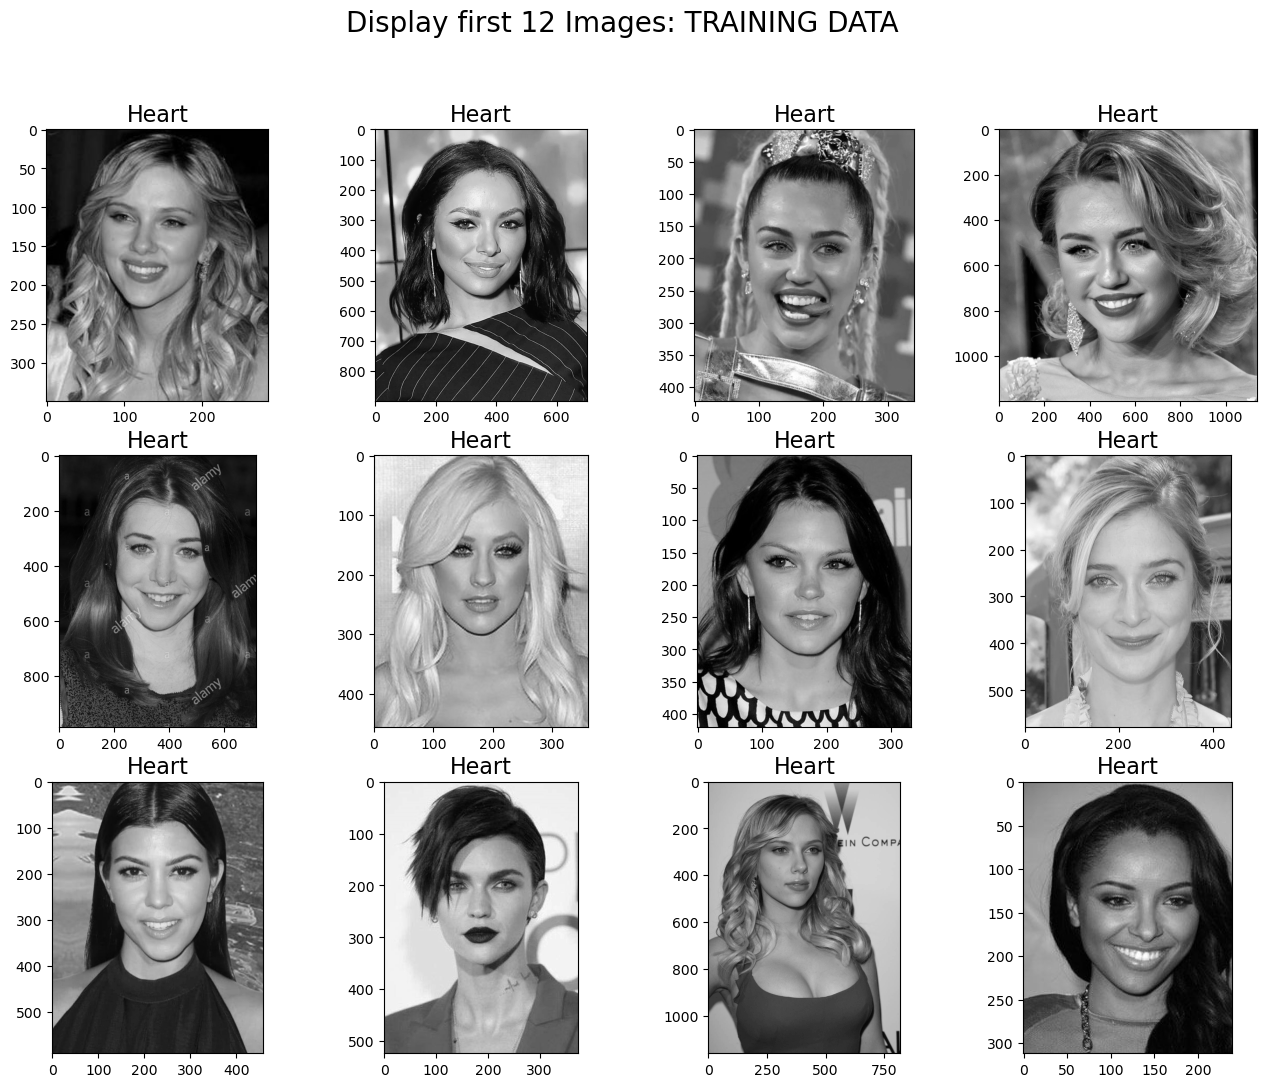

In [53]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', label_map, ncols=4)


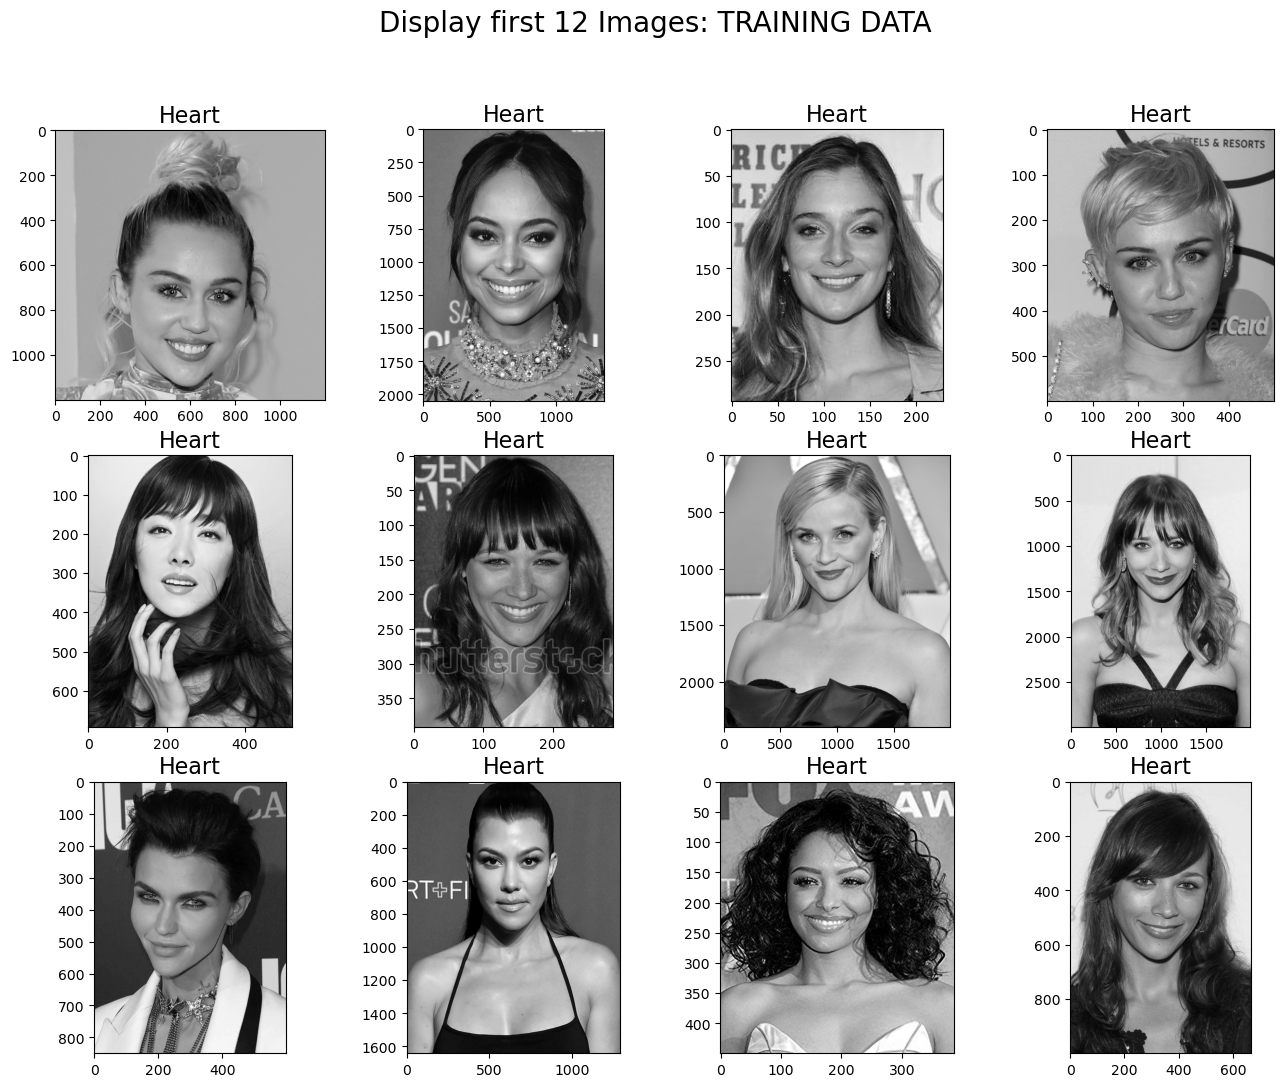

In [54]:
show_img(12, training_data[12:], 'Display first 12 Images: TRAINING DATA', label_map, ncols=4)

In [60]:
def create_data_files(directory, array, type=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        
        if type == 'aspect':
            try:
                for img in img_list:            
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # read in default color Grayscale
                    img_array = crop_and_resize(img_array) # call a function to crop & resize maintain aspect ratio
                    array.append([img_array, class_num])
                    i += 1
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')
        
        elif type == 'gray':
            try:
                for img in img_list:            
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    gray_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2GRAY) # convert to Gray
                    array.append([gray_array, class_num])   # 0=image, 1=class 
                    i += 1               
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        elif type == 'rgb':
            try:
                for img in img_list:            
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    rgb_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2RGB) # convert to RGB
                    array.append([rgb_array, class_num])   # 0=image, 1=class
                    i += 1                
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        else:
            print("Please specify image type ['aspect', 'gray', 'rgb']")
            break

        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")

In [61]:

def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [62]:
def train_test_prep(training_data_array, testing_data_array):
    
    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)
    
    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)  
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [63]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/pickle/'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'    
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [108]:
# create path to images in examples
ex_path = 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path, i).replace("\\", "/")
    examples.append(img)
    
examples = sorted(examples)
examples


['C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (30).jpg',
 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (41).jpg',
 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (420).jpg',
 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (43).jpg',
 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (54).jpg',
 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (7).jpg',
 'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/landscape.jpg']

In [80]:
portrait = cv2.imread(
    'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (30).jpg', 
    cv2.IMREAD_GRAYSCALE)
landscape = cv2.imread(
    'C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/landscape.jpg',
    cv2.IMREAD_GRAYSCALE)


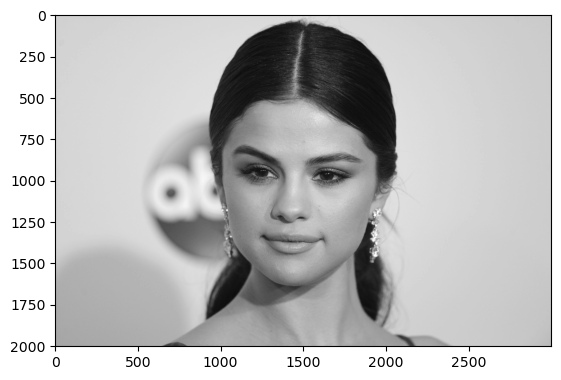

In [79]:
plt.imshow(landscape,cmap='gray')

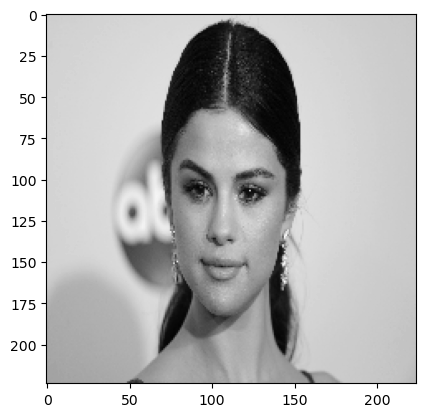

In [81]:

# auto resize by 224 - will be distorted
resized_lscp = cv2.resize(landscape,(224,224))
plt.imshow(resized_lscp, cmap='gray')

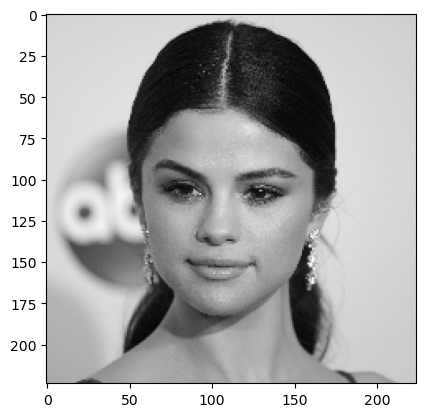

In [86]:

# test if the function works on landscape photos
new_lscp = crop_and_resize(landscape)
plt.imshow(new_lscp,cmap='gray');

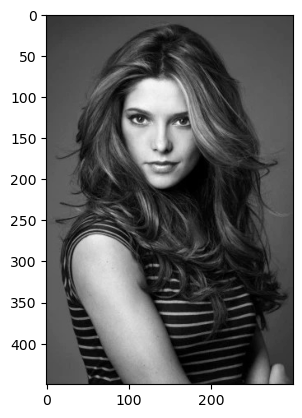

In [82]:

# original image
plt.imshow(portrait,cmap='gray');

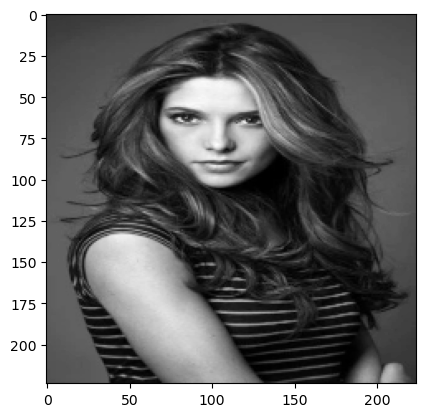

In [83]:

# auto resize by 224 - will be distorted
resized_ptrt = cv2.resize(portrait,(224,224))
plt.imshow(resized_ptrt, cmap='gray')
     

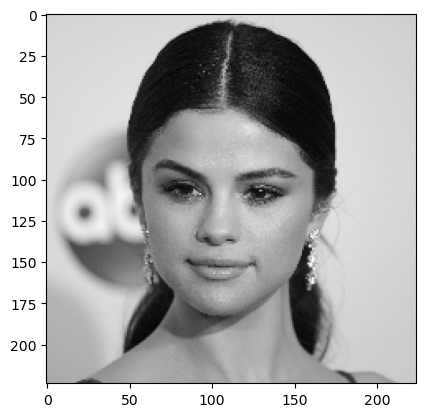

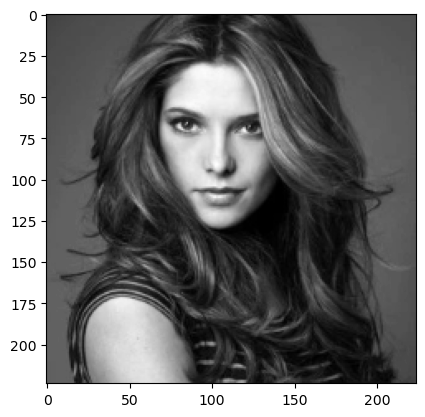

In [85]:

# test if the function works on portrait photos
new_lscp = crop_and_resize(portrait)
plt.imshow(new_lscp,cmap='gray');

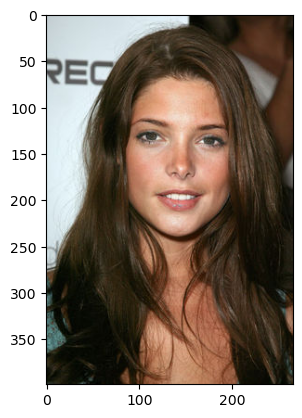

In [89]:
img = cv2.imread('C:/Users/Asus/Python files fr/SEM 6/FaceShape/FaceShape Dataset/example/heart (54).jpg')
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img2);

In [90]:

# creates detector
detector = MTCNN()
# detect faces in an image
results = detector.detect_faces(img2)
results

1/1 [==============================] - 0s 85ms/step


[{'box': [82, 60, 121, 175],
  'confidence': 0.9987959861755371,
  'keypoints': {'left_eye': (115, 132),
   'right_eye': (175, 135),
   'nose': (146, 169),
   'mouth_left': (116, 193),
   'mouth_right': (169, 194)}}]

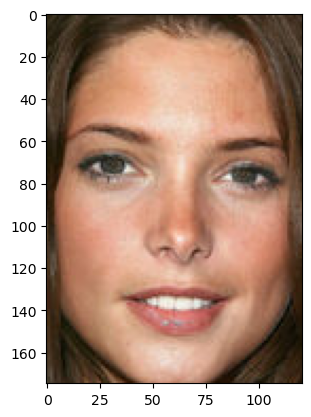

In [91]:
# extract the bounding box from the face

x1, y1, width, height = results[0]['box']
x2, y2 = x1+width, y1+height

face = img2[y1:y2, x1:x2]
plt.imshow(face);

x1 = 82
x2 = 203
y1 = 60
y2 = 235


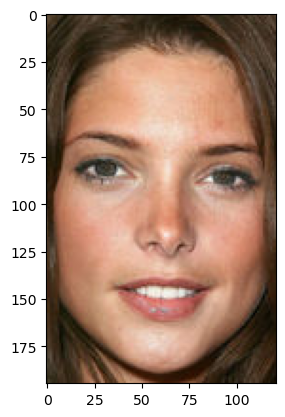

In [97]:

print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}')

# first fix the heights by adding 10 pix each side
face_2 = img2[y1-10:y2+10, x1:x2];
plt.imshow(face_2);
     

h=205
w=121


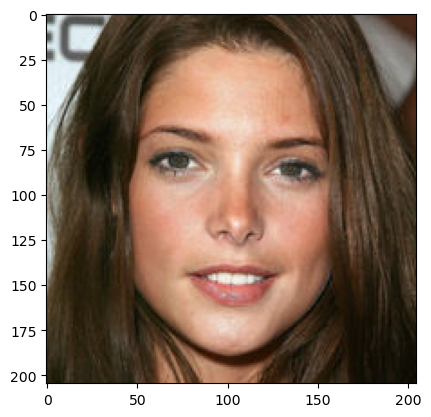

In [98]:

# then add the width to be square
h = (y2+20) - (y1-10)
w = x2-x1
print(f'h={h}')
print(f'w={w}')

adj_h = 10
adj_w = int((h-w)/2)

new_y1 = y1-adj_h
new_y2 = y2+(adj_h*2)

new_x1 = x1-adj_w
new_x2 = x2+adj_w

new_face = img2[new_y1:new_y2, new_x1:new_x2]
plt.imshow(new_face);

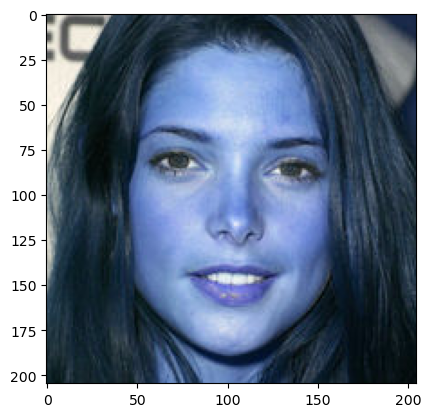

In [99]:

bgr = cv2.cvtColor(new_face,cv2.COLOR_RGB2BGR)
plt.imshow(bgr);
     

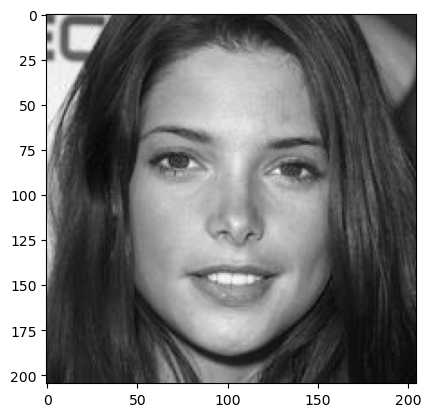

In [100]:

gray = cv2.cvtColor(new_face,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray');

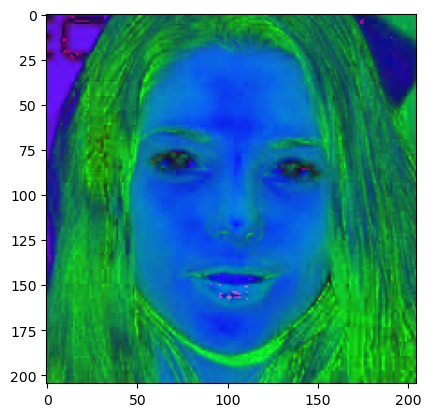

In [101]:

hsv = cv2.cvtColor(new_face,cv2.COLOR_RGB2HSV)
plt.imshow(hsv,cmap='gray');

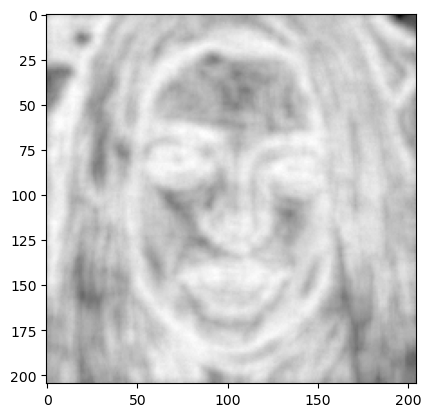

In [102]:

entropy = entropy(gray,disk(5))
plt.imshow(entropy,cmap='gray');


D:\ana\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


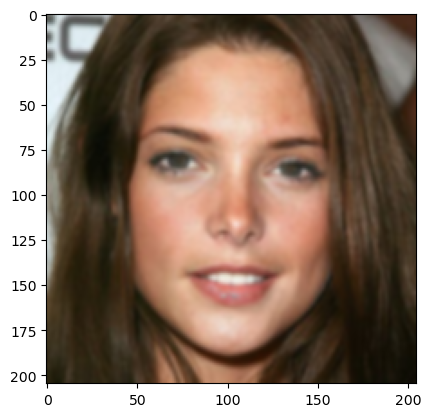

In [103]:

blur = gaussian(new_face)
plt.imshow(blur);

In [104]:
def extract_face(img, target_size=(224,224)):
    '''this functions extract face from different images by 
    1) finds the facial bounding box 
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling'''
           
    # 1. detect faces in an image
      
    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img

In [106]:

def cvt_gabor(gray_img):
    ksize = 3
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0
    
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gb_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)
    
    return(gb_img)

2/2 [==============================] - 0s 3ms/step


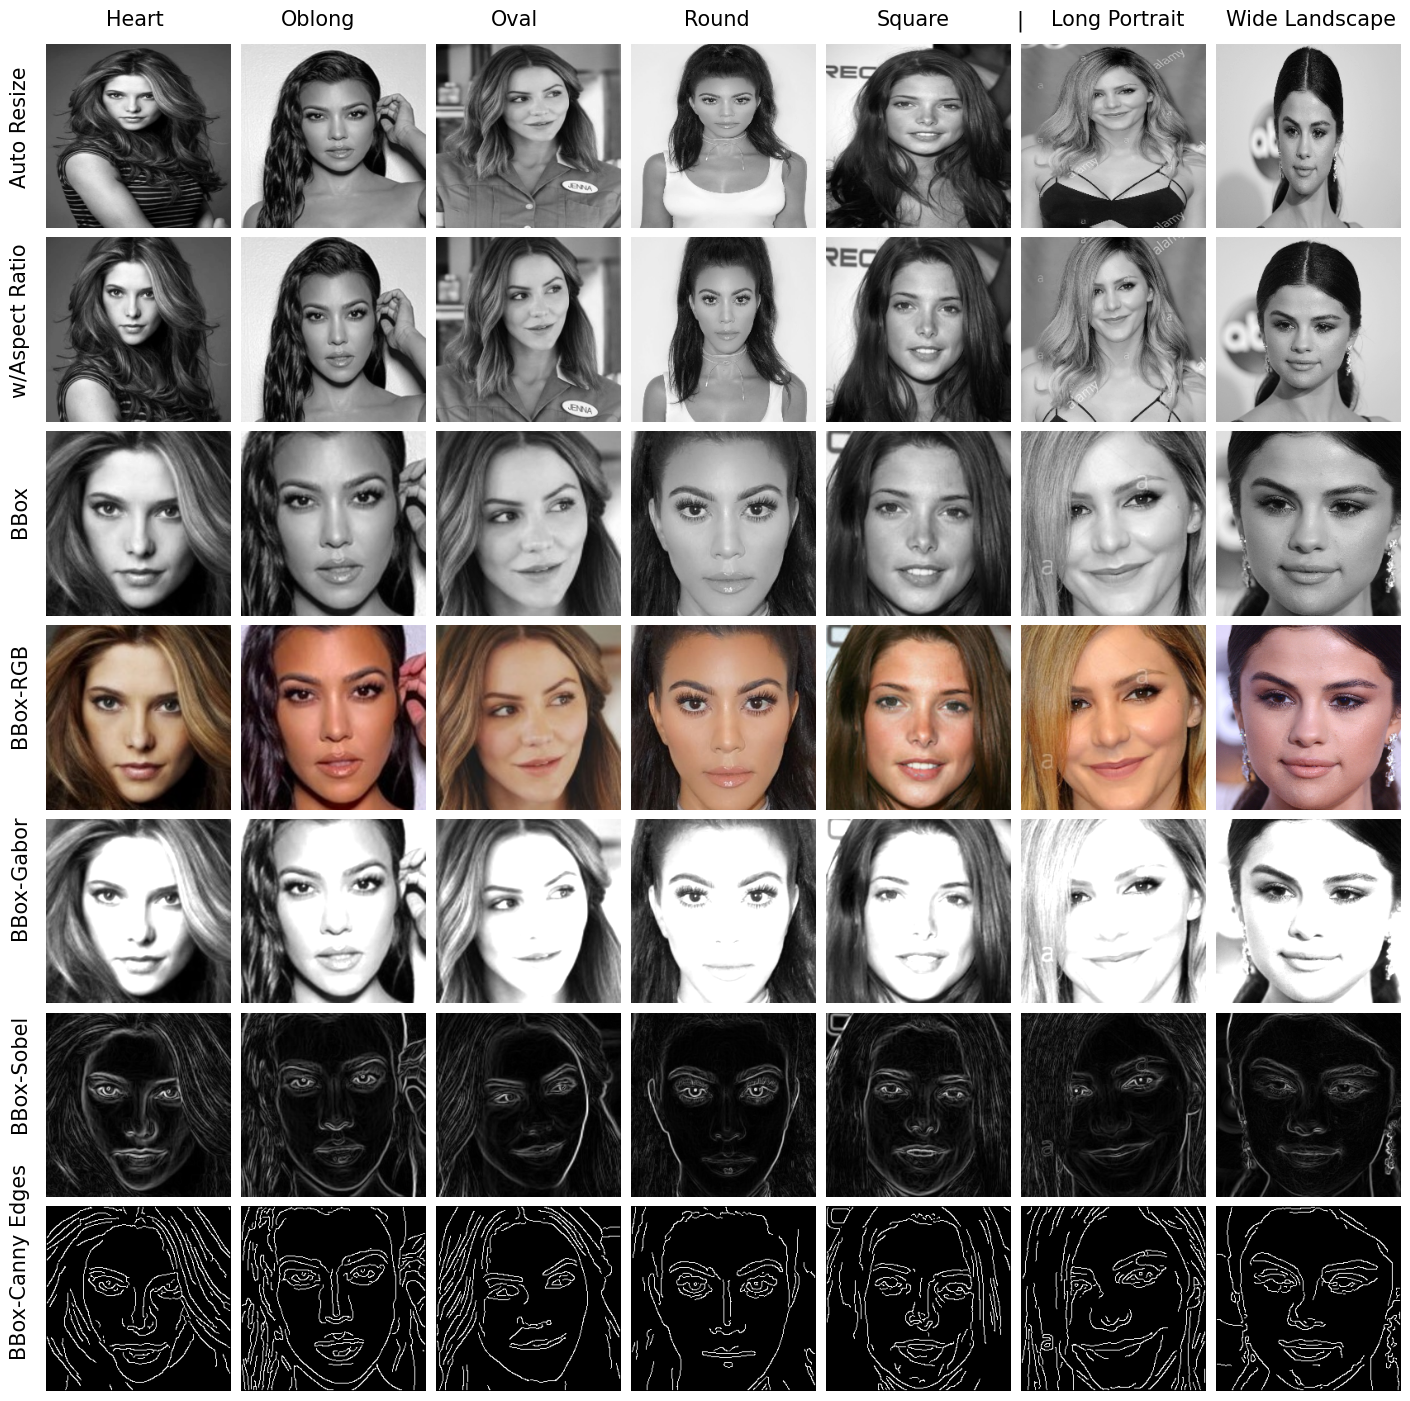

In [109]:
# test the function on the examples

n_images = len(examples)

fig, ax = plt.subplots(nrows=7, ncols=n_images, figsize=(n_images*2.5, (7*2.5)))
plt.gray()

ax= ax.ravel()

for i, file in enumerate(examples):
    
    img = cv2.imread(file)
    new_img = extract_face(img) # call function to extract face
    
    rsz_img = cv2.resize(img,(224,224))
    rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
    ax[i].imshow(rsz_img)
    ax[i].axis('off')
    
    aspct_img = crop_and_resize(img, target_w=224, target_h=224)
    aspct_img = cv2.cvtColor(aspct_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*1)].imshow(aspct_img)
    ax[i+(n_images*1)].axis('off')
    
    rgb_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
    ax[i+(n_images*3)].imshow(rgb_img)
    ax[i+(n_images*3)].axis('off')
    
    gray_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
    ax[i+(n_images*2)].imshow(gray_img)
    ax[i+(n_images*2)].axis('off')
        
    gabor_img = cvt_gabor(gray_img)
    ax[i+(n_images*4)].imshow(gabor_img)
    ax[i+(n_images*4)].axis('off')
    
    sobel_img = sobel(gray_img)
    ax[i+(n_images*5)].imshow(sobel_img)
    ax[i+(n_images*5)].axis('off')
    
    canny_img = canny(gray_img, sigma=1.5)
    ax[i+(n_images*6)].imshow(canny_img)
    ax[i+(n_images*6)].axis('off')
    
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.figtext(x=0.105, y=0.8, s="Auto Resize", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.68, s="w/Aspect Ratio", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.6, s="BBox", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.48, s="BBox-RGB", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.37, s="BBox-Gabor", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.26, s="BBox-Sobel", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.13, s="BBox-Canny Edges", fontsize=15, rotation=90)
plt.figtext(x=0.16, y=0.89, s="Heart", fontsize=15)
plt.figtext(x=0.26, y=0.89, s="Oblong", fontsize=15)
plt.figtext(x=0.38, y=0.89, s="Oval", fontsize=15)
plt.figtext(x=0.49, y=0.89, s="Round", fontsize=15)
plt.figtext(x=0.6, y=0.89, s="Square", fontsize=15)
plt.figtext(x=0.68, y=0.89, s="|", fontsize=15)
plt.figtext(x=0.7, y=0.89, s="Long Portrait", fontsize=15)
plt.figtext(x=0.8, y=0.89, s="Wide Landscape", fontsize=15);

In [112]:
def plot_results(mod_history, metric, epochs):
      
      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [113]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')


In [114]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [115]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

In [116]:

# create new training & testing data with resizing

training_data_apr = []
testing_data_apr = []

create_data_files(train_dir, training_data_apr, 'aspect')
create_data_files(test_dir, testing_data_apr, 'aspect')

Images processed: 800 of 4000
Images processed: 1600 of 4000
Images processed: 2400 of 4000
Images processed: 3200 of 4000
Images processed: 4000 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000


In [117]:

X_train, X_test, y_train, y_test = train_test_prep(training_data_apr, testing_data_apr)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (4000, 224, 224)
X_test.shape (1000, 224, 224)
y_train.shape (4000, 5)
y_test.shape (1000, 5)


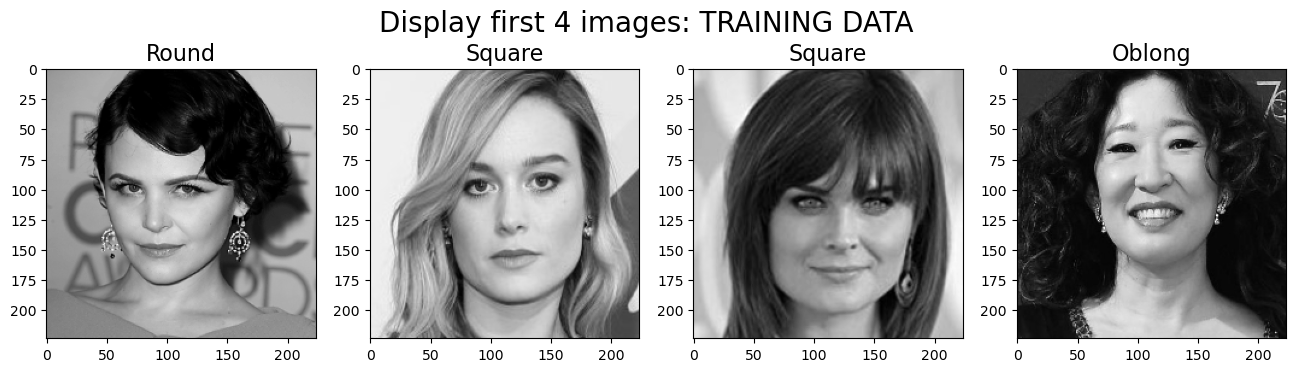

In [118]:

show_img(4, training_data_apr[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

In [119]:
 #pickle_out(X_train, X_test, y_train, y_test, 'apr')